# Style Transfer Crash Course
## Bornhack 2019

### Import libraries

In [1]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image

# Keras is only used to load VGG19 model as a high level API to TensorFlow 
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras import backend as K

# image functions
from PIL import Image
from IPython.core.display import HTML, display, Image as DisplayImage

# numPy is used for manipulation of array of object i.e Image in our case
import numpy as np

Using TensorFlow backend.


In [2]:
from style_transfer import load_img, deprocess_img

##### Confirm virtual environment

In [3]:
!python --version

Python 3.7.0


In [4]:
!pip freeze

absl-py==0.7.1
appnope==0.1.0
astor==0.8.0
astroid==2.2.5
attrs==19.1.0
backcall==0.1.0
bleach==3.1.0
cycler==0.10.0
decorator==4.4.0
defusedxml==0.6.0
entrypoints==0.3
gast==0.2.2
google-pasta==0.1.7
grpcio==1.22.0
h5py==2.9.0
ipykernel==5.1.1
ipython==7.6.1
ipython-genutils==0.2.0
isort==4.3.21
jedi==0.14.1
Jinja2==2.10.1
json5==0.8.5
jsonschema==3.0.1
jupyter-client==5.3.1
jupyter-core==4.5.0
jupyterlab==1.0.2
jupyterlab-server==1.0.0
Keras==2.2.4
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.0
kiwisolver==1.1.0
lazy-object-proxy==1.4.1
Markdown==3.1.1
MarkupSafe==1.1.1
matplotlib==3.1.1
mccabe==0.6.1
mistune==0.8.4
nbconvert==5.5.0
nbformat==4.4.0
notebook==6.0.0
numpy==1.16.4
pandocfilters==1.4.2
parso==0.5.1
pexpect==4.7.0
pickleshare==0.7.5
Pillow==6.1.0
prometheus-client==0.7.1
prompt-toolkit==2.0.9
protobuf==3.9.0
ptyprocess==0.6.0
Pygments==2.4.2
pylint==2.3.1
pyparsing==2.4.2
pyrsistent==0.15.3
python-dateutil==2.8.0
PyYAML==5.1.1
pyzmq==18.0.2
scipy==1.3.0
Send2Trash==

##### Visualization Functions 

In [5]:
def display_side_to_side_two(path1, path2, width=300, height=400):
    display(HTML("<table><tr><td><img src='{0}' width={2} height={3}></td><td><img src='{1}' width={2} height={3}></td></tr></table>".format(path1, path2, width, height)))
    
def display_side_to_side_three(path1, path2, path3, width=300, height=400):
    display(HTML("<table><tr><td><img src='{0}' width={3} height={4}></td><td><img src='{1}' width={3} height={4}></td><td><img src='{2}' width={3} height={4}></td></tr></table>".format(path1, path2, path3, width, height)))

### Config 
We need to define a couple of key parameters ahead of time.

##### Input images for content and style

In [6]:
# path where the content and style images are located
content_path = 'data/contents/content-horseduck.jpg'
style_path = 'data/styles/style-dali-2.jpg'

Quick visual inspection.

In [7]:
display_side_to_side_two(content_path, style_path, width=400)

,


In [8]:
# path to where Vgg19 model weight is located 
vgg_weights = "data/vgg_weights/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"

##### Output generated image

In [9]:
# save the result as
save_name = 'generated.jpg'

#####  ML parameters

In [10]:
num_iterations = 200
content_weight = 0.1
style_weight = 0.9

##### Other

In [11]:
# list of layers to be considered for calculation of Content and Style Loss
content_layers = ['block3_conv3']
style_layers = ['block1_conv1','block2_conv2','block4_conv3']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Visual Investigation

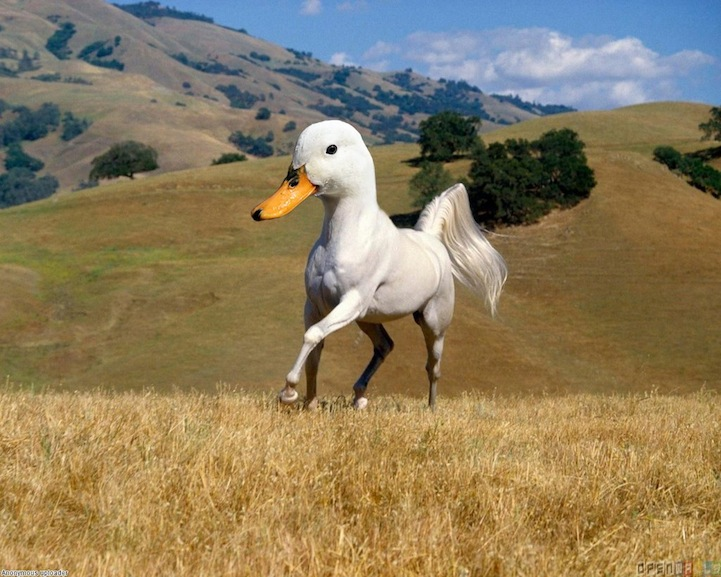

In [12]:
display(DisplayImage(content_path, width=400))

In [13]:
display_side_to_side_two(content_path, style_path, width=400)

,


### Loss Functions

##### Get Features

In [14]:
def get_feature_representations(model, content_path, style_path, num_content_layers):
    """
    Used to pass content and style image through the model.
    """

    # Load our images in 
    content_image = load_img(content_path)
    style_image   = load_img(style_path)

    # batch compute content and style features
    content_outputs = model(content_image)
    style_outputs   = model(style_image)

    # Get the style and content feature representations from our model  
    style_features   = [ style_layer[0]  for style_layer    in style_outputs[num_content_layers:] ]
    content_features = [ content_layer[0] for content_layer in content_outputs[:num_content_layers] ]

    return style_features, content_features

##### Content Loss

In [15]:
def get_content_loss(content, target):
    return tf.reduce_mean(tf.square(content - target)) /2

##### Style Loss

In [16]:
def get_style_loss(base_style, gram_target):

    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    # Original eqn as a constant to divide i.e 1/(4. * (channels ** 2) * (width * height) ** 2)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) / (channels**2 * width * height) #(4.0 * (channels ** 2) * (width * height) ** 2)

##### Gram Matrix

In [17]:
def gram_matrix(input_tensor):

    # if input tensor is a 3D array of size Nh x Nw X Nc
    # we reshape it to a 2D array of Nc x (Nh*Nw)
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]

    # get gram matrix 
    gram = tf.matmul(a, a, transpose_a=True)

    return gram

##### Combine Losses

In [18]:
def compute_loss(model, loss_weights, generated_output_activations, 
                 gram_style_features, content_features, 
                 num_content_layers, num_style_layers):

    generated_content_activations = generated_output_activations[:num_content_layers]
    generated_style_activations   = generated_output_activations[num_content_layers:]

    style_weight, content_weight = loss_weights

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, generated_style_activations):
        temp = get_style_loss(comb_style[0], target_style)
        style_score += weight_per_style_layer * temp

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, generated_content_activations):
        temp = get_content_loss(comb_content[0], target_content)
        content_score += weight_per_content_layer* temp

    # Get total loss
    loss = style_weight*style_score + content_weight*content_score 


    return loss, style_score, content_score

### Model 

In [19]:
# Using Keras Load VGG19 model
def get_model(content_layers,style_layers):

    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg19 = VGG19(weights=None, include_top=False)

    # We don't need to (or want to) train any layers of our pre-trained vgg model, so we set it's trainable to false.
    vgg19.trainable = False

    style_model_outputs = [vgg19.get_layer(name).output for name in style_layers]
    content_model_outputs = [vgg19.get_layer(name).output for name in content_layers]

    model_outputs = content_model_outputs + style_model_outputs

    # Build model 
    return Model(inputs = vgg19.input, outputs = model_outputs),  vgg19

### Style Transfer

##### Start a session

In [20]:
# Create a tensorflow session 
sess = tf.Session()

# Assign keras back-end to the TF session which we created
K.set_session(sess)

##### Obtain the model

In [21]:
model, vgg19 = get_model(content_layers,style_layers)

W0804 19:00:13.321584 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 19:00:13.323088 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 19:00:13.327296 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 19:00:13.359419 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Cra

#####  Get the style

In [22]:
# Get the style and content feature representations (from our specified intermediate layers) 
style_features, content_features = get_feature_representations(model, content_path, style_path, num_content_layers)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

##### Normalization

In [23]:
# VGG default normalization
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means 

##### TF variable for generated image

In [24]:
# load the original content image, as it will become the generated one
generated_image = load_img(content_path)

# create tensorflow variable to hold a stylized/generated image during the training 
generated_image = tf.Variable(generated_image, dtype=tf.float32)

# pass it to the model
model_outputs = model(generated_image)

##### Losses & Optimizer

In [25]:
# weightages of each content and style images i.e alpha & beta
loss_weights = (style_weight, content_weight)

In [26]:
# Create our optimizer
loss = compute_loss(model, loss_weights, model_outputs, gram_style_features, content_features, num_content_layers, num_style_layers)
opt = tf.train.AdamOptimizer(learning_rate=9, beta1=0.9, epsilon=1e-1).minimize( loss[0], var_list = [generated_image])

##### Initialize the TF variables

In [27]:
sess.run(tf.global_variables_initializer())
sess.run(generated_image.initializer)

##### Load the downloaded vgg19 weights

In [28]:
# loading the weights again because tf.global_variables_initializer() resets the weights
vgg19.load_weights(vgg_weights)

W0804 19:00:14.427534 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0804 19:00:14.428642 4533851584 deprecation_wrapper.py:119] From /Users/mateuszjurewicz/Bornhack ML Crashcourse/bornhack_ml_crashcourse/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



In [29]:
# Put loss as infinity before training starts and Create a variable to hold best image (i.e image with minimum loss)
best_loss, best_img = float('inf'), None

### Main Training Loop

In [ ]:
for i in range(num_iterations):

    # Do optimization
    sess.run(opt)

    # Make sure image values stays in the range of max-min value of VGG norm 
    clipped = tf.clip_by_value(generated_image, min_vals, max_vals)
    # assign the clipped value to the tensor stylized image
    generated_image.assign(clipped)


    # Open the Tuple of tensors 
    total_loss, style_score, content_score = loss
    total_loss = total_loss.eval(session=sess)


    if total_loss < best_loss:

        # Update best loss and best image from total loss. 
        best_loss = total_loss

        # generated image is of shape (1, h, w, 3) convert it to (h, w, 3)
        temp_generated_image = sess.run(generated_image)[0]
        best_img = deprocess_img(temp_generated_image)

        s_loss = sess.run(style_score)
        c_loss = sess.run(content_score)

        # print best loss
        print('best: iteration: ', i ,'loss: ', total_loss ,'  style_loss: ',  s_loss,'  content_loss: ', c_loss)

    # Save image after every X iterations 
    if (i+1)%10 == 0:
        output = Image.fromarray(best_img)
        output.save(str(i+1)+'-'+save_name)
        
        # show
        display_side_to_side_three(content_path, style_path, str(i+1)+'-'+save_name)

# after num_iterations iterations are completed, close the TF session 
sess.close()

best: iteration:  0 loss:  105032220.0   style_loss:  116700760.0   content_loss:  15529.515
best: iteration:  1 loss:  87701464.0   style_loss:  97442050.0   content_loss:  36254.582


### Inspection

Show us the final images.

In [ ]:
display(DisplayImage(content_path, width=600))

In [ ]:
display(DisplayImage(style_path, width=600))

In [ ]:
display(DisplayImage(str(200)+'-'+save_name, width=600))